# Experiment steps
`goal`
1. 特徵簡單前處理後全部丟進 XGBoost 訓練，看 `v1` 模型成果
2. 移除無法解釋 feature 後，將 feature importance 高的 feature set，做特徵轉換等 feature fusion，訓練最終模型
3. 透過 10-fold cross-validation 驗證最終模型穩定性
4. 對挑選出的變數做值域觀察，做出合理的因果結論
    * 欄位分析
    * 關聯性分析

In [432]:
import pandas as pd
import numpy as np
import re
import os
import xgboost as xgb
import matplotlib.pyplot as plt
import shap
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from sklearn.metrics import (roc_auc_score, 
                             precision_recall_curve, 
                             average_precision_score, 
                             mean_squared_error)

In [433]:
lists = pd.read_csv('csv/listings.csv')
lists.columns

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'description',
       'neighborhood_overview', 'picture_url', 'host_id', 'host_url',
       'host_name', 'host_since', 'host_location', 'host_about',
       'host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_thumbnail_url', 'host_picture_url',
       'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'neighbourhood',
       'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude',
       'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms',
       'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price',
       'minimum_nights', 'maximum_nights', 'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_maximum_nights',
       'maximum_maximum_nights', 'minimum_nights_avg_ntm',
       'maximum_nights_avg_ntm', 'calendar_upd

# V1 模型訓練

## preprocessing

* 將 Y (price) type 轉為 integer

In [434]:
def remove_unused_char(price):
    return re.sub(r'(\$|,|\.00)', '', price)

Y = lists['price'].apply(lambda x: remove_unused_char(x)).astype('int32').reset_index(drop=True)

* 掌握 Y 的分佈，選定2成資料為高房價 (threshold >= `2857`) 將 Y 轉為類別型

In [435]:
print(' Y percentile:')
print(Y.quantile([.1,.2,.3,.4,.5,.6,.7,.8,.9,1]))
Y_categ = pd.cut(Y, bins=[min(Y)-1, 2857, max(Y)], labels=[0, 1]).cat.codes
print('\n category Y value distribution')
Y_categ.value_counts()

 Y percentile:
0.1       580.0
0.2       800.0
0.3      1000.0
0.4      1229.0
0.5      1490.0
0.6      1754.8
0.7      2143.0
0.8      2857.0
0.9      4229.4
1.0    300245.0
Name: price, dtype: float64

 category Y value distribution


0    4212
1    1047
dtype: int64

 * 取出類別特徵，只要不是很離散 (distinct count <= 100)，就採用進 v1 模型   
 * 數值特徵，直接進 v1 模型

In [436]:
X = lists.drop(['price'], axis=1)
obj_col = X.dtypes[X.dtypes == np.object].index
print(' Categorical columns')
print(obj_col)

remove_col = X[obj_col].nunique() > 100  # Remove column as unique value greater than 100
remove_col = remove_col.index[remove_col]
print(' Remove columns:')
print(remove_col)
X = X.drop(remove_col, axis=1).reset_index(drop=True)

 Categorical columns
Index(['listing_url', 'last_scraped', 'name', 'description',
       'neighborhood_overview', 'picture_url', 'host_url', 'host_name',
       'host_since', 'host_location', 'host_about', 'host_response_time',
       'host_response_rate', 'host_acceptance_rate', 'host_is_superhost',
       'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood',
       'host_verifications', 'host_has_profile_pic', 'host_identity_verified',
       'neighbourhood', 'neighbourhood_cleansed', 'property_type', 'room_type',
       'bathrooms_text', 'amenities', 'has_availability',
       'calendar_last_scraped', 'first_review', 'last_review',
       'instant_bookable'],
      dtype='object')
 Remove columns:
Index(['listing_url', 'name', 'description', 'neighborhood_overview',
       'picture_url', 'host_url', 'host_name', 'host_since', 'host_location',
       'host_about', 'host_thumbnail_url', 'host_picture_url',
       'host_verifications', 'neighbourhood', 'amenities', 'first_rev

 * 類別轉數值

In [437]:
def category_to_num(df):
    df = df.apply(lambda x: pd.factorize(x)[0] if x.dtype == 'bool' or x.dtype == 'object' else x)
    return df

X_v1 = category_to_num(X)
X_v1

,id,scrape_id,last_scraped,host_id,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_neighbourhood,host_listings_count,...,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,74641,20210330225037,0,393116,-1,-1,0,0,0,4.0,...,10.0,9.0,9.0,NaN,0,2,0,2,0,0.43
1,178036,20210330225037,0,851825,0,0,1,0,1,9.0,...,10.0,10.0,10.0,NaN,1,9,0,1,1,0.69
2,271733,20210330225037,0,242033,1,0,1,1,2,0.0,...,10.0,10.0,10.0,NaN,0,1,1,0,0,0.57
3,289296,20210330225037,1,1338052,0,0,2,1,3,4.0,...,10.0,10.0,9.0,NaN,0,2,2,0,0,0.32
4,289298,20210330225037,0,1338052,0,0,2,1,3,4.0,...,10.0,10.0,9.0,NaN,0,2,2,0,0,1.93
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5254,48846513,20210330225037,2,9544894,0,15,1,0,-1,2.0,...,NaN,NaN,NaN,NaN,0,2,2,0,0,NaN
5255,48853952,20210330225037,1,102493558,0,0,1,1,3,2.0,...,NaN,NaN,NaN,NaN,0,2,1,0,1,NaN
5256,48854439,20210330225037,1,221534550,1,41,10,0,11,42.0,...,NaN,NaN,NaN,NaN,0,42,42,0,0,NaN
5257,48855237,20210330225037,1,298910458,0,1,12,1,0,7.0,...,NaN,NaN,NaN,NaN,0,4,4,0,0,NaN


## Split train and test data

In [438]:
def _split(data, ratio=0.9, seed=0):
    train, valid = train_test_split(
        data, train_size=ratio, random_state=seed
    )
    return train, valid

train, valid = _split(pd.concat([X_v1, Y], axis=1), ratio=0.9)
train_categY, valid_categY = _split(pd.concat([X_v1, Y_categ], axis=1), ratio=0.9)

# category Y
X_train_categY = train_categY.iloc[:, :-1]
X_test_categY = valid_categY.iloc[:, :-1]
y_train_categY = train_categY.iloc[:, -1]
y_test_categY = valid_categY.iloc[:, -1]

# numerical Y
X_train = train.iloc[:, :-1]
X_test = valid.iloc[:, :-1]
y_train = train.iloc[:, -1]
y_test = valid.iloc[:, -1]

## Train v1 model by XGBClassfier

In [439]:
# Train
xgbc = xgb.XGBClassifier(eval_metric='error')
xgbc.fit(X_train_categY, y_train_categY)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='error',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=1, tree_method='exact',
              validate_parameters=1, verbosity=None)

In [440]:
# Predict
y_prob = xgbc.predict_proba(X_test_categY)[:,1]

In [441]:
# Evaluation
auc = roc_auc_score(y_test_categY, y_prob)
auc

0.9664452393118719

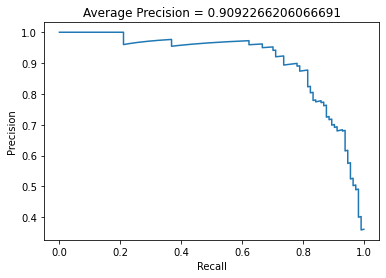

In [442]:
precision_list, recall_list, _ = precision_recall_curve(y_test_categY, y_prob)
plt.plot(recall_list, precision_list)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Average Precision = ' + str(average_precision_score(y_test_categY, y_prob)))
plt.show()
plt.close()

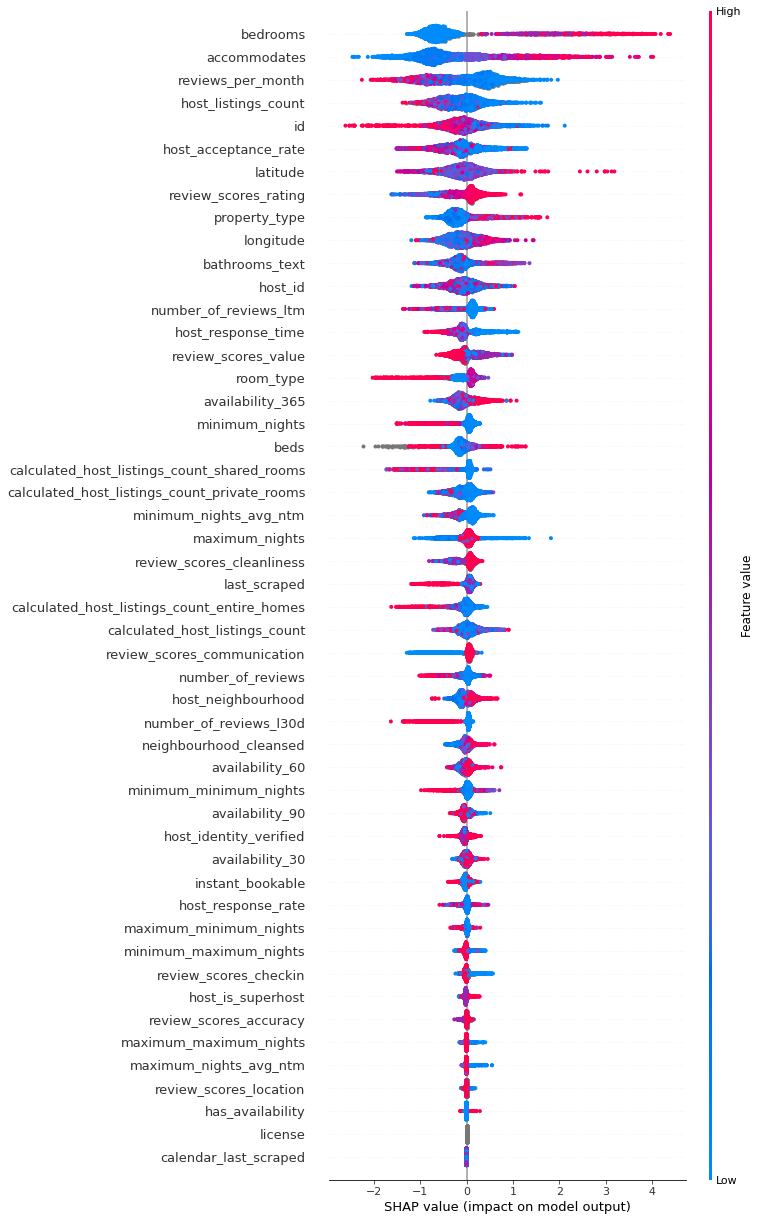

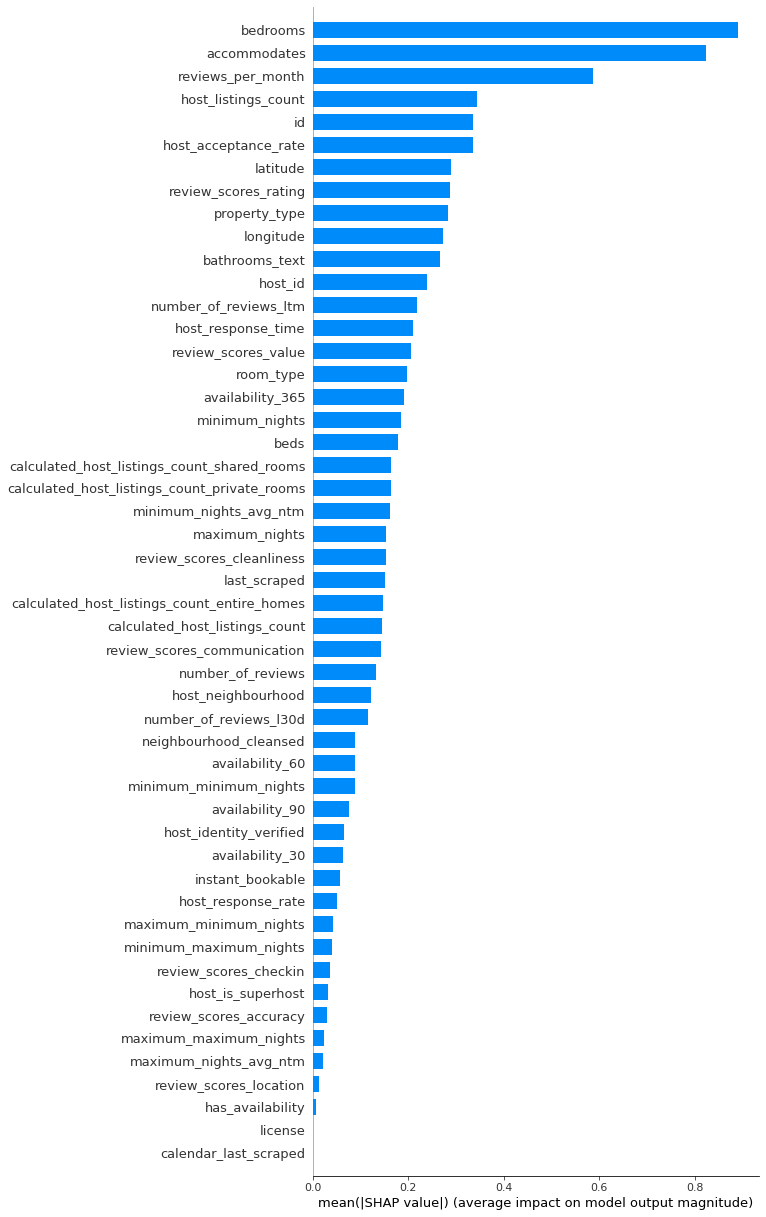

In [443]:
# feature importance
explainer = shap.TreeExplainer(xgbc)
shap_values = explainer.shap_values(X_train_categY)
shap.summary_plot(shap_values, X_train_categY, max_display=50)
shap.summary_plot(shap_values, X_train_categY, max_display=50, plot_type="bar")

## Train v1 model by XGBRegressor

In [444]:
xgbr = xgb.XGBRegressor(eval_metric='error')
xgbr.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, eval_metric='error',
             gamma=0, gpu_id=-1, importance_type='gain',
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=8,
             num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
             scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [445]:
y_pred = xgbr.predict(X_test)

In [446]:
mse = np.sqrt(mean_squared_error(y_test, y_pred))
mse

3965.4951396491656

# V1 模型結論
* 變數數量: 56
* 訓練與測試資料分割比例為: 80/20
* XGBC 將房價(Y)前20%與後80%區分為高低房價
1. 進 XGBoost classifier 訓練
    * AUC:96.6
    * average precision: 90.9%
2. 進 XGBoost regression 訓練
    * root_mean_square_error: 3965.5
3. 透過 SHAP 選出重要特徵如下
    * bedrooms - 床位越多，價格越貴
    * accommodates - 容納人數越多，價格越貴
    * reviews_per_month - 月回覆比例越小，價格越貴
    * host_listings_count - 屋主出租物件越少，價格越貴
    * host_acceptance_rate - `為類別物件，是非循序為數值，只確定相關尚無法確定因果`
    * latitude - 緯度在南北兩端(應該山區)，價格越貴
    * review_scores_rating - 用戶打的分數越高，價格越貴
    * property_type - 房型 `類別物件`
    * longitude - 越靠東(信義區)，價格越貴
    * number_of_reviews_ltm - 不知道是什麼，review 數越少，價格越貴
    * host_response_time - `類別物件`
    * availability_365 - 可利用天數越多，房價越貴
    * minimum_nights - 停留天數越短，價格越貴

# V2 模型訓練
* 選取重要的特徵
* 將類別物件用較好方式轉換為數值
* 計算 V2 model 成效

## 選取重要的特徵

In [447]:
X_v2 = X[['bedrooms',
          'accommodates', 
          'reviews_per_month', 
          'host_listings_count', 
          'host_acceptance_rate',
          'latitude',
          'review_scores_rating',
          'property_type',
          'longitude',
          'number_of_reviews_ltm',
          'host_response_time',
          'availability_365',
          'minimum_nights']]

## 將類別物件用較好方式轉換為數值

In [448]:
# 將 host_response_time 透過 dictionary 轉換為數值
transform_dict = {"host_response_time": {"within an hour": 0, 
                                         "within a few hours": 1, 
                                         "within a day": 2, 
                                         "a few days or more": 3, "N/A": 4}}
X_v2 = X_v2.replace(transform_dict)

# 將 host_acceptance_rate 的 % 去掉轉成數值
X_v2['host_acceptance_rate'] = X_v2['host_acceptance_rate'].str.replace(r'(％|%|NaN)', '', regex=True).astype('float32')

# 將 property_type 直接轉換 (因類型有64種並無序)
X_v2['property_type'] = X_v1['property_type']
X_v2



,bedrooms,id,accommodates,reviews_per_month,host_listings_count,host_acceptance_rate,latitude,review_scores_rating,property_type,longitude,number_of_reviews_ltm,host_response_time,availability_365,minimum_nights
0,1.0,74641,3,0.43,4.0,0.0,25.05343,88.0,0,121.54621,0,NaN,89,3
1,1.0,178036,1,0.69,9.0,100.0,25.04446,92.0,1,121.51346,4,0.0,0,1
2,2.0,271733,2,0.57,0.0,100.0,25.00581,99.0,2,121.55518,4,1.0,120,5
3,2.0,289296,4,0.32,4.0,96.0,25.04287,94.0,2,121.55112,0,0.0,365,28
4,1.0,289298,2,1.93,4.0,96.0,25.08091,97.0,2,121.55902,15,0.0,350,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5254,2.0,48846513,7,NaN,2.0,100.0,25.03133,NaN,3,121.55798,0,0.0,171,30
5255,1.0,48853952,1,NaN,2.0,100.0,25.10214,NaN,7,121.52381,0,0.0,87,5
5256,1.0,48854439,4,NaN,42.0,88.0,25.02530,NaN,2,121.49680,0,1.0,90,30
5257,1.0,48855237,2,NaN,7.0,89.0,25.04866,NaN,3,121.55076,0,0.0,90,2


## 計算模型成效

In [449]:
train, valid = _split(pd.concat([X_v2, Y], axis=1), ratio=0.9)
train_categY, valid_categY = _split(pd.concat([X_v2, Y_categ], axis=1), ratio=0.9)

# category Y
X_train_categY = train_categY.iloc[:, :-1]
X_test_categY = valid_categY.iloc[:, :-1]
y_train_categY = train_categY.iloc[:, -1]
y_test_categY = valid_categY.iloc[:, -1]

# numerical Y
X_train = train.iloc[:, :-1]
X_test = valid.iloc[:, :-1]
y_train = train.iloc[:, -1]
y_test = valid.iloc[:, -1]

## Train v2 model by XGBClassfier

In [450]:
# Train
xgbc = xgb.XGBClassifier(eval_metric='error')
xgbc.fit(X_train_categY, y_train_categY)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='error',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=1, tree_method='exact',
              validate_parameters=1, verbosity=None)

In [451]:
# Predict
y_prob = xgbc.predict_proba(X_test_categY)[:,1]

In [452]:
# Evaluation
auc = roc_auc_score(y_test_categY, y_prob)
auc

0.9567790836314086

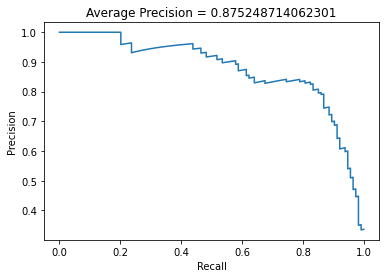

In [453]:
precision_list, recall_list, _ = precision_recall_curve(y_test_categY, y_prob)
plt.plot(recall_list, precision_list)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Average Precision = ' + str(average_precision_score(y_test_categY, y_prob)))
plt.show()
plt.close()

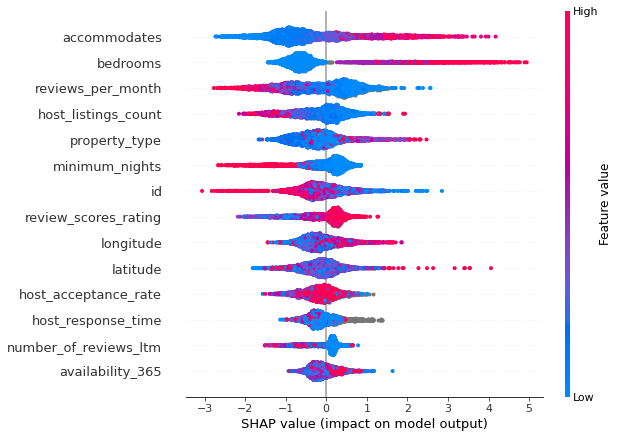

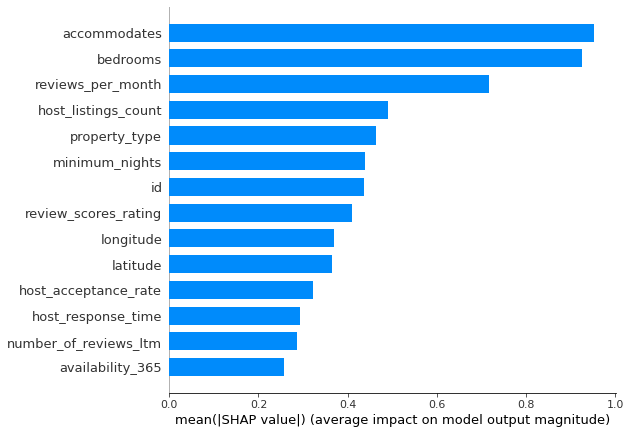

In [454]:
# feature importance
explainer = shap.TreeExplainer(xgbc)
shap_values = explainer.shap_values(X_train_categY)
shap.summary_plot(shap_values, X_train_categY, max_display=20)
shap.summary_plot(shap_values, X_train_categY, max_display=20, plot_type="bar")

In [455]:
xgbr = xgb.XGBRegressor(eval_metric='error')
xgbr.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, eval_metric='error',
             gamma=0, gpu_id=-1, importance_type='gain',
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=8,
             num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
             scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [456]:
y_pred = xgbr.predict(X_test)

In [457]:
mse = np.sqrt(mean_squared_error(y_test, y_pred))
mse

3287.7738073785335

# V2 模型結論
* 變數數量: 13
* 訓練與測試資料分割比例為: 80/20
* XGBC 將房價(Y)前20%與後80%區分為高低房價
1. 進 XGBoost classifier 訓練
    * AUC:96.6 -> 95.2
    * average precision: 90.9% -> 85%
2. 進 XGBoost regression 訓練
    * root_mean_square_error: 3965.5 -> 2665
    
`RMSE 相較 baseline V1 model 降低非常多`

# 透過 10-fold cross-validation 驗證最終模型穩定性

In [458]:
def k_fold_cv(X, Y, k=10):
    mse_list = []
    for i in range(k):
        # split data to X and Y
        train, valid = _split(pd.concat([X, Y], axis=1), ratio=0.8, seed=i)
        X_train = train.iloc[:, :-1]
        X_test = valid.iloc[:, :-1]
        y_train = train.iloc[:, -1]
        y_test = valid.iloc[:, -1]

        # Train
        xgbr = xgb.XGBRegressor(eval_metric='error')
        xgbr.fit(X_train, y_train)

        # Predict and evaluate
        y_pred = xgbr.predict(X_test)
        mse_list.append(np.sqrt(mean_squared_error(y_test, y_pred)))

    print(mse_list)
    print(sum(mse_list) / len(mse_list))

In [459]:
k_fold_cv(X_v1, Y, k=10)
k_fold_cv(X_v2, Y, k=10)

[5174.382014082133, 11490.591233588677, 11061.288092515495, 7386.0679669446945, 11771.378821170281, 8002.208711323813, 6095.191559360381, 5494.2869174501775, 6058.90636466076, 7508.480545993027]
8004.278222708944
[6755.10699014165, 11778.498964536708, 11251.146438290487, 8197.563508550958, 11048.987138083798, 7515.591914477472, 6335.135953285621, 5623.691539453477, 6946.484269065403, 8419.467433638245]
8387.167414952382
